## Загрузка данных

In [1]:
# Загрузим сразу все дефолтные библиотеки, которые могут нам потребоваться при работе над данным проектом
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
# Функция для подсчета количества пропусков
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
missing_data(df)

,Total,Percent
Пол,0,0.0
Возраст,0,0.0
Зарплата,0,0.0
Члены семьи,0,0.0
Страховые выплаты,0,0.0


In [7]:
# Узнаем количество дубликатов
df.duplicated().sum()

153

In [8]:
# Сразу же дропнем наши дубликаты
df = df.drop_duplicates(ignore_index=True)
df.duplicated().sum()

0

In [9]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


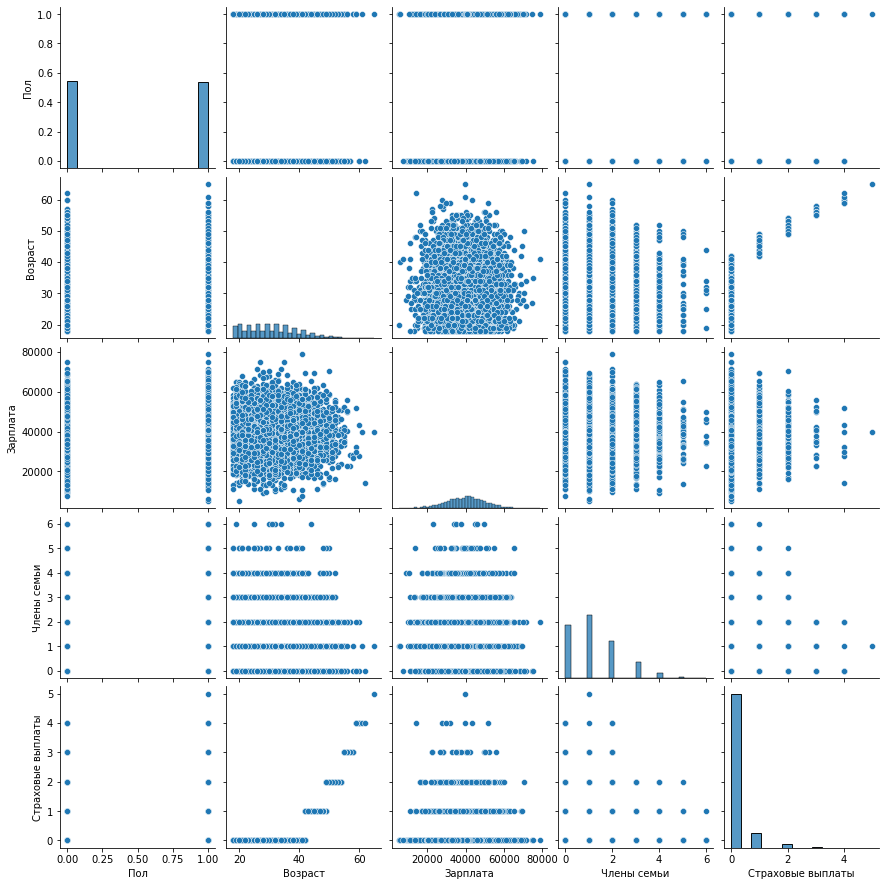

In [10]:
# Более детально посмотрим на наши фичи и таргет
sns.pairplot(df)
plt.show()

Мы выполнили небольшую подготовку наших данных, а так же изучили распределения наших признаков. 

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$a = Xw$$

Задача обучения:

$$w = \arg\min_w MSE(Xw, y)$$

Формула обучения:

$$w = (X^T X)^{-1} X^T y$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** Не изменится, так как обратимая матрица сократится при расчетах, и в результате мы получим исходную формулу предсказания.

**Обоснование:** 

Умножим матрицу признаков на некую обратимую матрицу $P$

$$w_2 = ((XP)^T XP)^{-1} (XP)^T y$$

По свойству $(AB)^T = B^T A^T$

$$w_2 = (P^T X^T XP)^{-1} P^T X^T y$$

По свойству $(AB)^{-1} = B^{-1} A^{-1}$

$$w_2 = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$$

По свойству $A^{-1} A = A A^{-1} = E$

$$w_2 = P^{-1} (X^T X)^{-1} E X^T y$$

По свойству $AE = EA = A$

$$w_2 = P^{-1} (X^T X)^{-1} X^T y$$

Вспомним как выглядит наша формула обучения и сделаем замену в нашем уравнении

$$w_2 = P^{-1} w$$

Вернёмся к предсказаниям

$$a_2 = X P w_2$$

Подставим уже выведенное нами $w_2$

$$a_2 = X P P^{-1} w$$

По свойству $A^{-1} A = A A^{-1} = E$

$$a_2 = XEw$$

По свойству $AE = EA = A$

$$a_2 = Xw = a$$

Таким образом мы доказали, что $a$ = $a_2$. Иными словами, предсказания модели никак не изменятся несмотря на умножение матрицы признаков на обратимую матрицу $P$, а следовательно и качество линейной регрессии.

## Алгоритм преобразования

**Алгоритм**

1. Сгенерируем рандомную обратимую матрицу 
2. Докажем ее обратимость
3. Умножим матрицу признаков на обратимую матрицу, таким образом получая новую матрицу признаков
4. Выводим метрики качества для исходных и сгенерированных признаков

**Обоснование**

Выше мы уже расписывали умножение нашей матрицы признаков на обратимую матрицу $P$, в результате которого результат, а именно предсказания линейной регрессии никак не изменились. Соответственно не поменяется и качество модели ;) 

## Проверка алгоритма

In [11]:
# Создадим функцию генерации рандомной обратимой матрицы нужного нам размера
def invertible_matrix(size):
    try:
        matrix = np.linalg.inv(np.random.normal(size=(size, size)))
    except np.linalg.LinAlgError: # вдруг у нас с первого раза не получится обратимая :)
        matrix = invertible_matrix(size)
    
    return matrix

In [12]:
# Разобьем наш датасет на фичи и таргер
x = df.drop(columns='Страховые выплаты')
y = df['Страховые выплаты']

In [13]:
# Проверим, что с размерностью все ок
x.shape, y.shape

((4847, 4), (4847,))

In [14]:
# Получим новые фичи с помощью нашей функции 
new_x = x @ invertible_matrix(x.shape[1])
new_x.shape

(4847, 4)

In [15]:
# Обучим нашу модельку на обеих выборках и сравним r2_score
model = LinearRegression()

model.fit(x, y)
predict = model.predict(x)

model.fit(new_x, y)
new_predict = model.predict(new_x)

# Сравним R2
print('R2 features = ', r2_score(y, predict))
print('R2 new_features = ', r2_score(y, new_predict))

R2 features =  0.4302010044852067
R2 new_features =  0.4302010044852025


# Общий вывод

1. Мы получили данные, посмотрели на распределение признаков.
2. Доказали, что при умножении признаков на обратимую матрицу качество линейной регрессии не изменится.
3. Запрограммировали данный алгоритм и проверили качество линейной регрессии до и после преобразований.

Мы создали метод, благодаря которому, мы сможем восстановить персональную информацию, а так же никак при этом не влиять на качество линейной регресии.